<IPython.core.display.Javascript object>


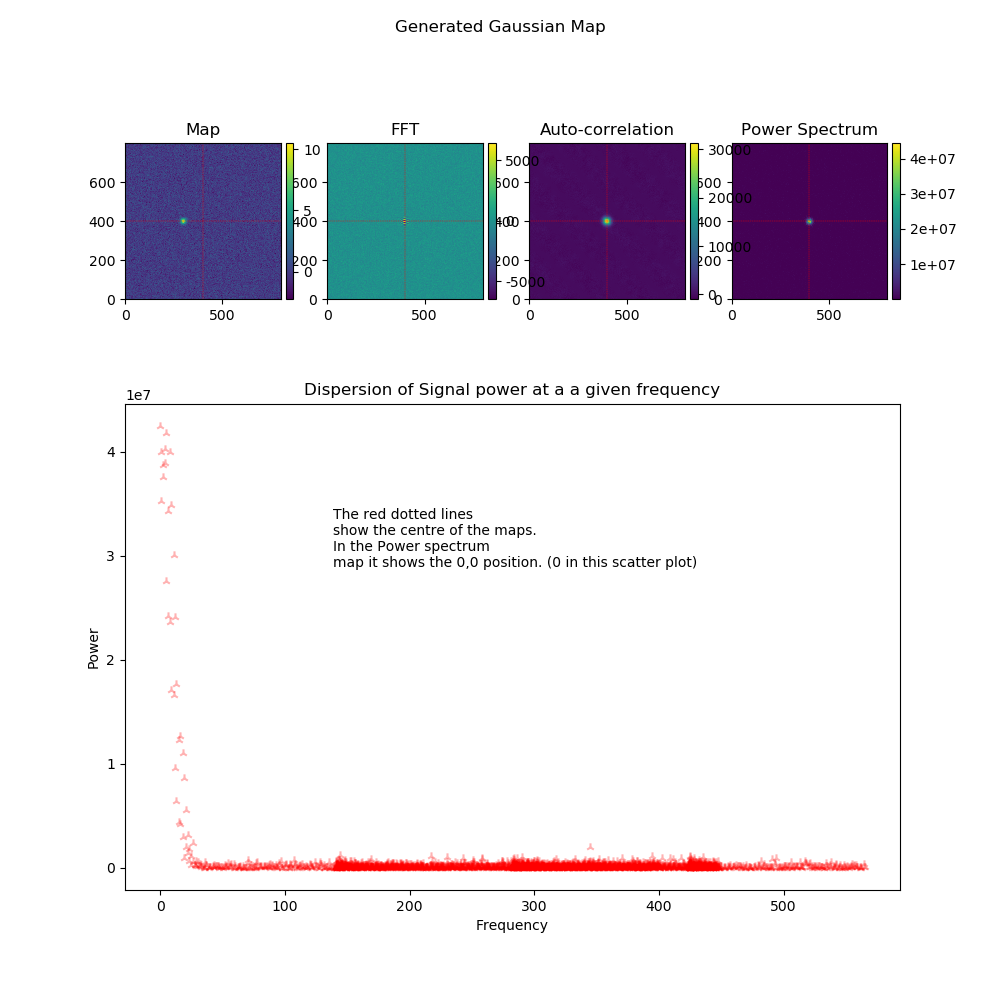

In [8]:
import numpy as np
from numpy.fft import fft2, ifft2
from astropy.modeling.models import Gaussian2D
import matplotlib.pyplot as plt
from itertools import permutations

%matplotlib nbagg

def colourbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    ax = mappable.axes
    figle = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return figle.colorbar(mappable, cax=cax, format='%g')


# scalar definitions
NoiPer = 0.05
x_shift = -100
y_shift = 0
# generating map
len_x, len_y = 800, 800
x = np.arange(len_x)
y = np.arange(len_y)
X, Y = np.meshgrid(x, y)

GaussParams = [10, len_x // 2 - 1 + x_shift, len_y // 2 - 1 + y_shift, 10, 10, 0]

G2D = Gaussian2D().evaluate(X, Y, *GaussParams)
noi = G2D.max() * NoiPer * np.random.normal(size=G2D.shape)

G2D += noi

# When the input a is a time-domain signal and A = fft(a),
# np.abs(A) is its amplitude spectrum and
# np.abs(A)**2 is its power spectrum.
# The phase spectrum is obtained by np.angle(A).

FFT_G2D = fft2(G2D)  # amplitude spectrum when np.abs(FFT_G2D) is used
FFT_G2D = np.roll(FFT_G2D, (FFT_G2D.shape[0] // 2) - 1, axis=(0, 1))

MidMapX = FFT_G2D.shape[1] // 2 - 1
MidMapY = FFT_G2D.shape[0] // 2 - 1
FFT_G2D = np.roll(FFT_G2D, (FFT_G2D.shape[0] - 1) // 2, axis=(0, 1))

PSD = FFT_G2D * FFT_G2D.conj()
PSD_rolled = np.roll(PSD, PSD.shape[0]//2-1, axis=(0, 1))

AC = ifft2(PSD)
AC_rolled = np.roll(AC.real, AC.shape[0]//2-1, axis=(0, 1))
AC_rolled[MidMapY, MidMapX] = 0

# Binning
loc = list(permutations(np.arange(0, G2D.shape[0]), 2))
radius, pows = [0], [PSD_rolled[PSD_rolled.shape[0]//2-1, PSD_rolled.shape[1]//2-1]]

for idx in loc:
    r = int(((idx[0] - MidMapX) ** 2 + (idx[1] - MidMapY) ** 2) ** (1 / 2) + 0.5)
    Pow = PSD_rolled[idx[0], idx[1]].real
    radius.append(r)
    pows.append(Pow)

fig1 = plt.figure(figsize=(10, 10))
grid = plt.GridSpec(3, 4, hspace=0.4, wspace=0.2)

MapIM = fig1.add_subplot(grid[0, 0])
fftIM = fig1.add_subplot(grid[0, 1])
acIM = fig1.add_subplot(grid[0, 2])
psdIM = fig1.add_subplot(grid[0, 3])
AvgScatter = fig1.add_subplot(grid[1:, :])
# MapIM.get_shared_x_axes().join(MapIM, fftIM)
fftIM.get_shared_x_axes().join(fftIM, acIM)
acIM.get_shared_x_axes().join(acIM, psdIM)
# MapIM.get_shared_y_axes().join(MapIM, fftIM)
fftIM.get_shared_y_axes().join(fftIM, acIM)
acIM.get_shared_y_axes().join(acIM, psdIM)

# row 1
MapIM.set_title('Map')
MapIM.hlines(y=G2D.shape[0]//2-1, xmin=0, xmax=G2D.shape[1], color='r', linestyles='--', linewidths=0.3)
MapIM.vlines(x=G2D.shape[1]//2-1, ymin=0, ymax=G2D.shape[0], color='r', linestyles='--', linewidths=0.3)
im1 = MapIM.imshow(G2D, origin='lower')
colourbar(im1)

fftIM.set_title('FFT')
fftIM.hlines(y=FFT_G2D.shape[0]//2-1, xmin=0, xmax=FFT_G2D.shape[1], color='r', linestyles='--', linewidths=0.3)
fftIM.vlines(x=FFT_G2D.shape[1]//2-1, ymin=0, ymax=FFT_G2D.shape[0], color='r', linestyles='--', linewidths=0.3)
im2 = fftIM.imshow(np.roll(FFT_G2D.real, FFT_G2D.shape[0]//2-1, axis=(0, 1)), origin='lower')
colourbar(im2)

# row 2
acIM.set_title('Auto-correlation')
acIM.hlines(y=AC_rolled.shape[0]//2-1, xmin=0, xmax=AC_rolled.shape[1], color='r', linestyles='--', linewidths=0.3)
acIM.vlines(x=AC_rolled.shape[1]//2-1, ymin=0, ymax=AC_rolled.shape[0], color='r', linestyles='--', linewidths=0.3)
im3 = acIM.imshow(AC_rolled.real, origin='lower')
colourbar(im3)

psdIM.set_title('Power Spectrum')
psdIM.hlines(y=PSD_rolled.shape[0]//2-1, xmin=0, xmax=PSD_rolled.shape[1], color='r', linestyles='--', linewidths=0.3)
psdIM.vlines(x=PSD_rolled.shape[1]//2-1, ymin=0, ymax=PSD_rolled.shape[0], color='r', linestyles='--', linewidths=0.3)
im4 = psdIM.imshow(PSD_rolled.real, origin='lower')
colourbar(im4)
# row 3
AvgScatter.set_title('Dispersion of Signal power at a a given frequency')
AvgScatter.set_xlabel('Frequency')
AvgScatter.set_ylabel('Power')
im5 = AvgScatter.scatter(radius[::200], pows[::200], marker='2', alpha=0.3, color='red')

fig1.suptitle('Generated Gaussian Map')

fig1.text(4/12, 5/12, 'The red dotted lines \nshow the centre of the maps.\n'
                      'In the Power spectrum \nmap it shows the 0,0 position. (0 in this scatter plot)\n')

plt.show()
